In [1]:
import numpy as np

import cvxpy as cp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import opt
import robustARMA_opt
from data import pert_S

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def error_metrics(Y_hat, Y_test, H=None, H_gt=None, print_results=True):
    # Normalized error
    if Y_test.ndim == 2:
        norm_y = (Y_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum(1) / norm_y)
    else:
        norm_y = (Y_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum((1,2)) / norm_y)
    
    if print_results:
        print(f"Error in signal y: {err_y}")

    if H is not None and H_gt is not None:
        # Error wrt ground truth filter
        if H.ndim == 3: # Several filters
            norm_H = (H_gt**2).sum((1,2))
            err_H = np.mean(((H - H_gt)**2).sum((1,2)) / norm_H)
        else:
            norm_H = (H_gt**2).sum()
            err_H = ((H - H_gt)**2).sum() / norm_H

        if print_results:
            print(f"Error in filter: {err_H}")
        return err_y, err_H

    return err_y

In [3]:
def plot_filters(Hs):
    if Hs.ndim == 3:
        n_filt = Hs.shape[0]
    else:
        n_filt = 1
    f, ax = plt.subplots(1, n_filt, figsize=(12,8))

    if n_filt > 1:
        for i in range(n_filt):    
            ax[i].imshow(Hs[i,:,:])
    else:
        ax.imshow(Hs)

# Reading the data

In [4]:
#data = np.load('data_temp/temperatures2003_mod_knn8_N40.npz')
#data = np.load('data_temp/temperatures2018_knn8_N28.npz') # 54 or 28 for only valid values, 36 for invalid values as well
data = np.load('data/air_quality2021CA_knn5_N28.npz')

In [5]:
A = data['A_bin']

pert_graph = True
if pert_graph:
    A = pert_S(A, eps=0.1) # Using default parameters rewire 10% of total links

norm_A = np.sqrt((A**2).sum())

temp_info = data['pm25'] # data['X']

norm_data = False
if norm_data:
    temp_info -= np.mean(temp_info, 1)[:,None]
    temp_info /= np.std(temp_info, 1)[:,None]

diff = False
if diff:
    temp_info = np.diff(temp_info, axis=1) / temp_info[:,:1]

norm_data = True
if norm_data:
    temp_info = temp_info / np.sqrt((temp_info**2).sum(1))[:,None]

Y = temp_info[:,1:]
X = temp_info[:,:-1]
N, N_dates = X.shape

In [6]:
train_test_split = 0.5

random_train_test = True
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

X_train = X[:,idxs_train]
Y_train = Y[:,idxs_train]
X_test = X[:,idxs_test]
Y_test = Y[:,idxs_test]
X_train.shape, Y_train.shape, X_test.shape, N_dates

((28, 182), (28, 182), (28, 182), 364)

# Models

In [7]:
models = []
errs_y = []
errs_H = []

In [8]:
# Ground truth obtained using Least squares over all samples
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_test - H @ X_test)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_gt = H.value

In [9]:
y_ls_perf = H_gt @ X_test
err_ls_per, err_H_ls_per = error_metrics(y_ls_perf, Y_test, H_gt, H_gt)
models.append("LS-Perfect (LB)"); errs_y.append(err_ls_per)

Error in signal y: 0.11069484001658945
Error in filter: 0.0


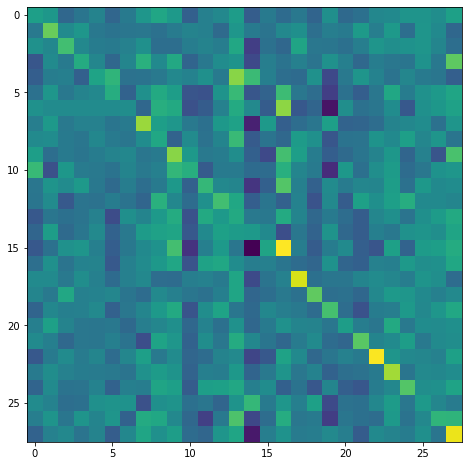

In [10]:
plot_filters(H_gt)

## Toy models for comparison

In [11]:
Y_random = Y_test.std(1)[:,None] * np.random.randn(*Y_test.shape) + Y_test.mean(1)[:,None]
err_random = error_metrics(Y_random, Y_test)
#models.append("Random Return"); errs_y.append(err_random)

Error in signal y: 0.6703766302673468


In [12]:
Y_zeros = np.zeros(Y_test.shape)
err_zeros = error_metrics(Y_zeros, Y_test)
#models.append("Zero Return"); errs_y.append(err_zeros)

Error in signal y: 1.0


In [13]:
# Identity - copying the temperature from the previous day
H_eye = np.eye(N)
Y_eye = H_eye @ X_test
err_eye = error_metrics(Y_eye, Y_test)
models.append("Copy Prev Day"); errs_y.append(err_eye)

Error in signal y: 0.20192373855530812


## Least squares

In [14]:
# Least squares
H = cp.Variable((N,N))#, symmetric=True)
obj = cp.sum_squares(Y_train - H @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_ls = H.value

In [15]:
Y_hat_ls = H_ls @ X_test
err_y_ls, err_H_ls = error_metrics(Y_hat_ls, Y_test, H_ls, H_gt)
models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)

Error in signal y: 0.2503288410753572
Error in filter: 1.8299912268455816


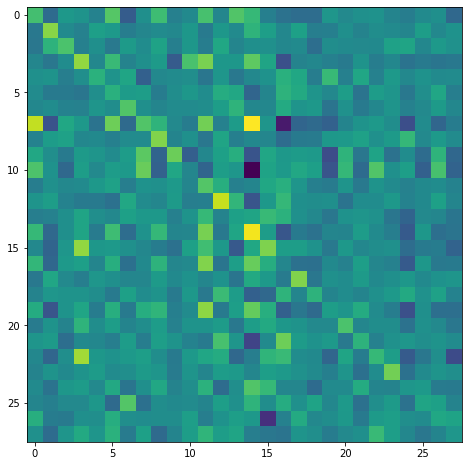

In [16]:
plot_filters(H_ls)

In [17]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
h = cp.Variable(K)
obj = cp.sum_squares(Y_train - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
h = h.value
H_ls_gf = np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0)

In [18]:
Y_hat_ls_gf = H_ls_gf @ X_test
err_y_ls_gf, err_H_ls_gf = error_metrics(Y_hat_ls_gf, Y_test, H_ls_gf, H_gt)
models.append("Least Squares-GF"); errs_y.append(err_y_ls_gf); errs_H.append(err_H_ls_gf)

Error in signal y: 0.17465601964795854
Error in filter: 0.873264666396143


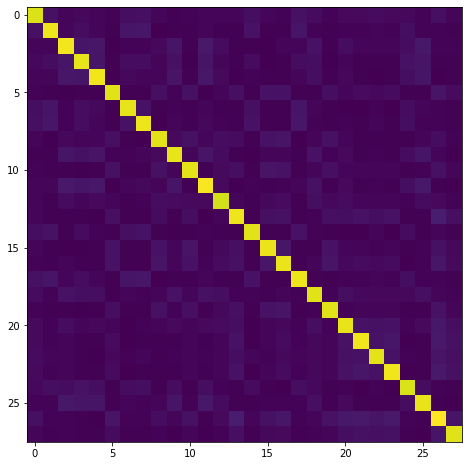

In [19]:
plot_filters(H_ls_gf)

## Iterative (robust) algorithms

In [20]:
args = [0.4, 0.008, 0.0005, 3.]
args = [0., 0., 0., 2.5]
args_no_st = [0.03, 0.005, 0., 3.5]
args_rew = [0.2, 0.1, 0.001, 0.0001, 1.1]
args_rew_no_st = [0.1, 0.08, 0., 5e-4, 1.]

In [21]:
X_norm = (X_train.T - np.mean(X_train.T, axis=0))/np.std(X_train.T, axis=0)

C = np.cov(X_norm.T)

In [22]:
iter, H_iter, S_iter = opt.estH_iter(X, Y, A, C, args)

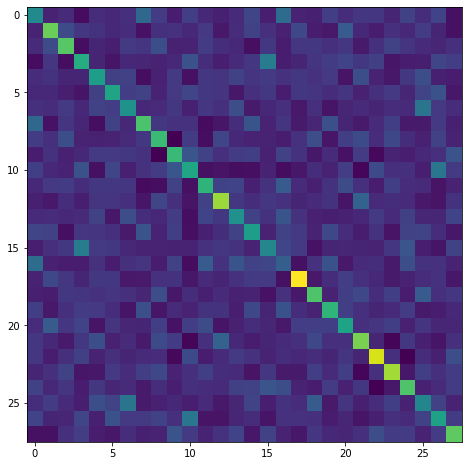

In [23]:
plot_filters(H_iter)

In [24]:
Y_hat_iter = H_iter @ X_test
err_iter, err_H_iter = error_metrics(Y_hat_iter, Y_test, H_iter, H_gt)
models.append("RGFI"); errs_y.append(err_iter); errs_H.append(err_H_iter)

Error in signal y: 0.1575380735230785
Error in filter: 0.7449410224295157


In [25]:
iter, H_iter_rew, S_iter_rew = opt.estH_iter_rew(X, Y, A, C, args_rew)

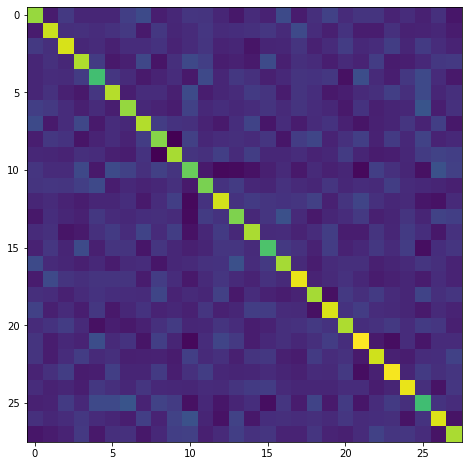

In [26]:
plot_filters(H_iter_rew)

In [27]:
Y_hat_iter_rew = H_iter_rew @ X_test
err_iter_rew, err_H_iter_rew = error_metrics(Y_hat_iter_rew, Y_test, H_iter_rew, H_gt)
models.append("RGFI-REW"); errs_y.append(err_iter_rew); errs_H.append(err_H_iter_rew)

Error in signal y: 0.16093145174395715
Error in filter: 0.800134551516928


In [28]:
((S_iter - A)**2).sum()

36.58942182025103

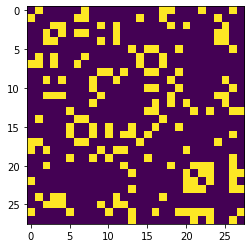

In [29]:
plt.imshow(S_iter)

$D^{-1/2} S D^{-1/2}$ -- para stationary

$D^{-1} S$ -- no simétrica

# Multiple filters ARMA model

In [30]:
P = 2
Xs = np.array([temp_info[:,p:-P+p] for p in range(P)])
Y_mult = temp_info[:,P:]
N_dates_mult = Y_mult.shape[1]
Xs.shape, Y_mult.shape

((2, 28, 363), (28, 363))

In [31]:
idxs_mult = idxs.copy() # Using same split as in the previous cases, but needs to be adapted
for p in range(N_dates-P, N_dates): # Deleting invalid occurrences for this case
    idxs_mult = idxs_mult[idxs_mult != p]
idxs_train = idxs_mult[:int(train_test_split*N_dates_mult)]
idxs_test = idxs_mult[int(train_test_split*N_dates_mult):]
Xs_train = Xs[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Y_mult_train = Y_mult[:,idxs_train]
Y_mult_test = Y_mult[:,idxs_test]

In [32]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_test - cp.sum([Hs[p] @ Xs_test[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_gt = np.array([Hs[p].value for p in range(P)])

In [33]:
Y_hat_perf = np.sum(Hs_gt @ Xs_test, 0)
err_mult_per = error_metrics(Y_hat_perf, Y_mult_test)
models.append("VARMA-LS-Perfect"); errs_y.append(err_mult_per)

Error in signal y: 0.08058613607417028


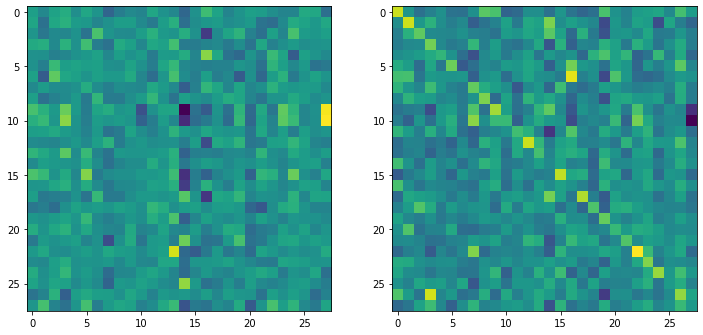

In [34]:
plot_filters(Hs_gt)

## Least squares

In [35]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_ls = np.array([Hs[p].value for p in range(P)])

In [36]:
Y_hat_mult_ls = np.sum(Hs_ls @ Xs_test, 0)
err_mult_ls, err_H_mult_ls = error_metrics(Y_hat_mult_ls, Y_mult_test, Hs_ls, Hs_gt)
models.append("VARMA-LS"); errs_y.append(err_mult_ls); errs_H.append(err_H_mult_ls)

Error in signal y: 0.31632173809317576
Error in filter: 2.171223133633123


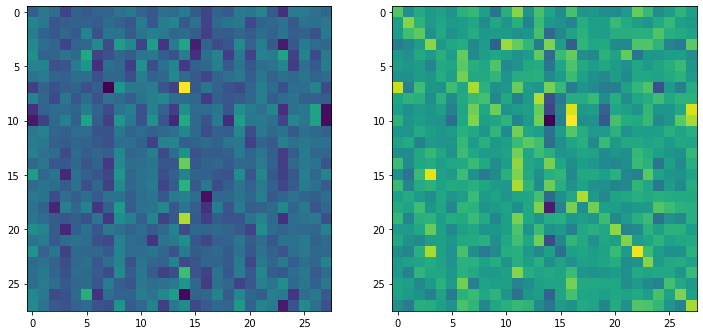

In [37]:
plot_filters(Hs_ls)

In [38]:
# Least squares postulating it is a graph filter
K = 5
hs = [cp.Variable(K) for _ in range(P)]
Hs = [cp.sum([hs[p][k] * Spow[k,:,:] for k in range(K)]) for p in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
hs_ls = np.array([hs[p].value for p in range(P)])
Hs_ls_gf = np.array([np.sum([hs_ls[p,k] * Spow[k,:,:] for k in range(5)], 0) for p in range(P)])

In [39]:
Y_hat_mult_ls_gf = np.sum(Hs_ls_gf @ Xs_test, 0)
err_y_mult_ls_gf, err_H_mult_ls_gf = error_metrics(Y_hat_mult_ls_gf, Y_mult_test, Hs_ls_gf, Hs_gt)
models.append("VARMA-LS-GF"); errs_y.append(err_y_mult_ls_gf); errs_H.append(err_H_mult_ls_gf)

Error in signal y: 0.18055026767515314
Error in filter: 0.9592561601920022


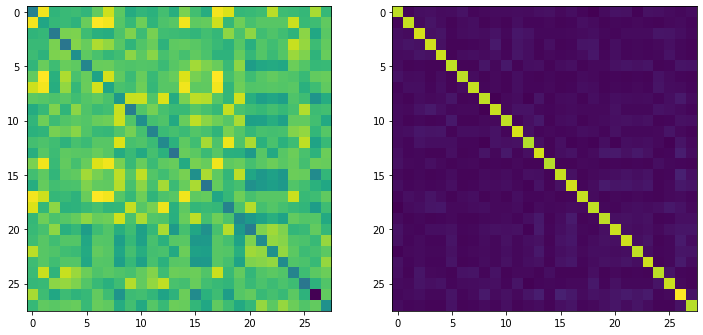

In [40]:
plot_filters(Hs_ls_gf)

## Iterative (robust) algorithms

In [41]:
from robustARMA_opt import estHs_iter, estHs_iter_rew

In [42]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [43]:
iter, Hs_iter, Ss_iter = estHs_iter(Xs_train, Y_mult_train, A, C, args)

In [44]:
((Ss_iter - A)**2).sum() / norm_A, ((Ss_iter - data['A_bin'])**2).sum() / norm_A

(2.034541135942016, 3.7436743014202727)

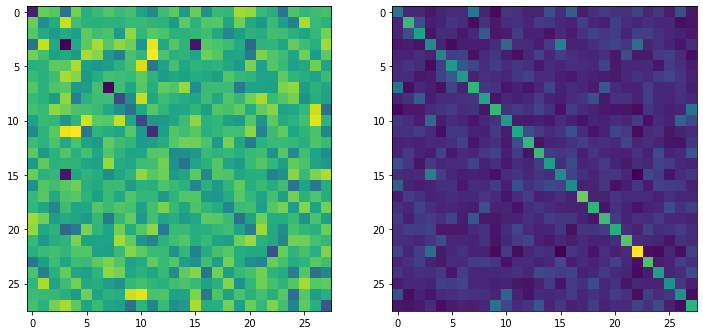

In [45]:
plot_filters(Hs_iter)

In [46]:
Y_hat_mult_iter = np.sum(Hs_iter @ Xs_test, 0)
err_mult_iter, err_Hs_mult_iter = error_metrics(Y_hat_mult_iter, Y_mult_test, Hs_iter, Hs_gt)
models.append("VARMA-RGFI"); errs_y.append(err_mult_iter); errs_H.append(err_Hs_mult_iter)

Error in signal y: 0.1866887339554805
Error in filter: 0.9590749978929882


In [47]:
iter, Hs_iter_rew, Ss_iter_rew = estHs_iter_rew(Xs_train, Y_mult_train, A, C, args_rew)

In [48]:
((Ss_iter_rew - A)**2).sum() / norm_A, ((Ss_iter_rew - data['A_bin'])**2).sum() / norm_A

(6.2128583933534705, 6.934776189497026)

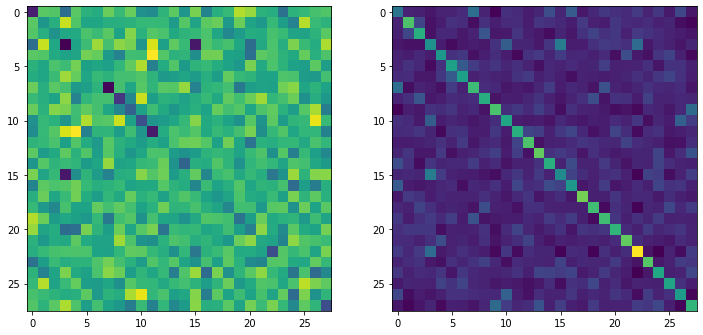

In [49]:
plot_filters(Hs_iter_rew)

In [50]:
Y_hat_mult_iter_rew = np.sum(Hs_iter_rew @ Xs_test, 0)
err_mult_iter_rew, err_Hs_mult_iter_rew = error_metrics(Y_hat_mult_iter_rew, Y_mult_test, Hs_iter_rew, Hs_gt)
models.append("VARMA-RGFI-REW"); errs_y.append(err_mult_iter_rew); errs_H.append(err_Hs_mult_iter_rew)

Error in signal y: 0.18303602530409688
Error in filter: 0.9482093884861418


# Representation

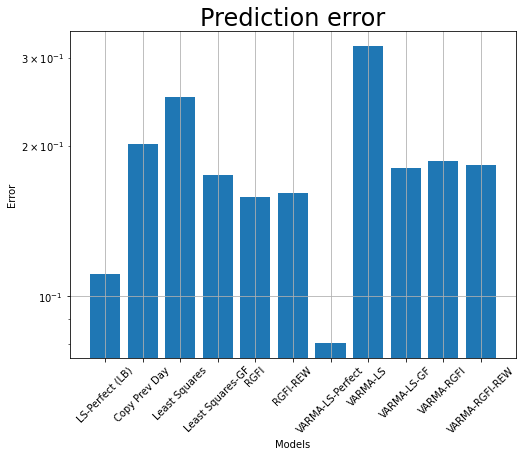

In [51]:
x_ax = np.arange(len(models))
plt.figure(figsize=(8,6))
plt.bar(x_ax, errs_y, log=True)
plt.xticks(x_ax, models, rotation=45)
plt.title("Prediction error", fontsize=24)
plt.xlabel("Models")
plt.ylabel("Error")
plt.grid()
#plt.ylim(0., 0.1)

# Multiple filters for multiple data

In [53]:
X1 = data['pm25']
X2 = data['oz']
X3 = data['pm10']
#X4 = data['press']
comp_data = np.array([
    X1,
    X2,
    X3,
#    X4
])
n_feat = comp_data.shape[0]

Ys = comp_data[:,:,1:].copy()
Xs = comp_data[:,:,:-1].copy()
Xs.shape, Ys.shape

((3, 28, 364), (3, 28, 364))

In [54]:
train_test_split = 0.6#1/6
N_dates = Xs.shape[2]

random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

Xs_train = Xs[:,:,idxs_train]
Ys_train = Ys[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Ys_test = Ys[:,:,idxs_test]
Xs_train.shape, Ys_train.shape, Xs_test.shape, N_dates

((3, 28, 218), (3, 28, 218), (3, 28, 146), 364)

In [55]:
Hs_gt = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_test[i,:,:] - H @ Xs_test[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_gt.append(H.value)
Hs_gt = np.array(Hs_gt)

In [56]:
Ys_hat_gt = Hs_gt @ Xs_test
err_y_gt, err_H_gt = error_metrics(Ys_hat_gt, Ys_test, Hs_gt, Hs_gt)
#models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_gt, err_H_gt

Error in signal y: 0.11078842970865298
Error in filter: 0.0


(0.11078842970865298, 0.0)

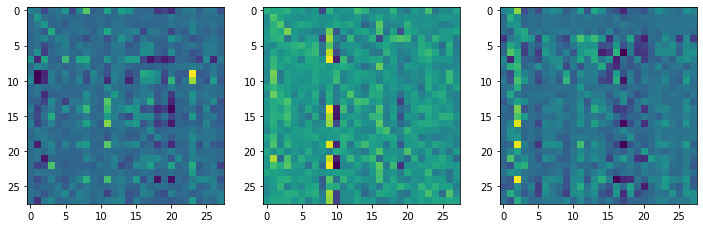

In [57]:
plot_filters(Hs_gt)

## Least squares

In [58]:
Hs_ls = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_train[i,:,:] - H @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_ls.append(H.value)
Hs_ls = np.array(Hs_ls)

In [59]:
Xs[1,:,:].max()

0.1

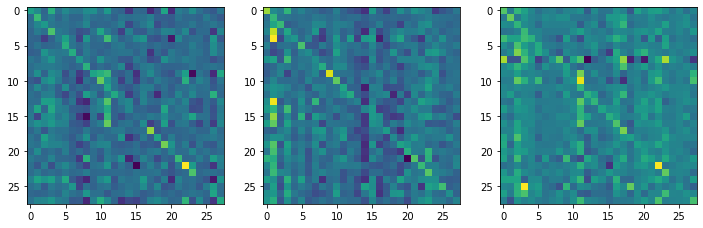

In [60]:
plot_filters(Hs_ls)

In [61]:
Ys_hat_ls = Hs_ls @ Xs_test
norm_y = (Ys_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
err_y = ((Ys_test - Ys_hat_ls)**2).sum((1,2)) / norm_y
err_y, norm_y

(array([0.37171851, 0.03067001, 0.29169244]),
 array([1.35561893e+06, 7.80448022e+00, 9.36457366e+06]))

In [62]:
Ys_hat_ls = Hs_ls @ Xs_test
err_y_ls, err_H_ls = error_metrics(Ys_hat_ls, Ys_test, Hs_ls, Hs_gt)
#models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_ls, err_H_ls

Error in signal y: 0.23136031998431542
Error in filter: 1.201475673523755


(0.23136031998431542, 1.201475673523755)

In [63]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
Hs_ls_gf = []
for i in range(n_feat):
    h = cp.Variable(K)
    obj = cp.sum_squares(Ys_train[i,:,:] - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    h = h.value
    Hs_ls_gf.append(np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0))
Hs_ls_gf = np.array(Hs_ls_gf)

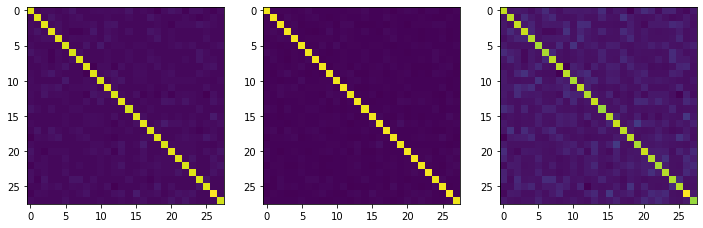

In [64]:
plot_filters(Hs_ls_gf)

In [65]:
Ys_hat_ls_gf = Hs_ls_gf @ Xs_test
err_y_ls, err_H_ls = error_metrics(Ys_hat_ls_gf, Ys_test, Hs_ls, Hs_gt)
#models.append("LS-GF"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_ls_gf, err_H_ls_gf

Error in signal y: 0.18573232796029351
Error in filter: 1.201475673523755


(0.17465601964795854, 0.873264666396143)

## Iterative (robust) algorithms

In [66]:
import sev_filters_opt

In [67]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [68]:
meanX = comp_data.mean(2)
stdX = comp_data.std(2)
Cs = np.zeros((n_feat, N, N))
for i in range(n_feat):
    X_norm = (comp_data[i,:,:].T - meanX[i,:]) / stdX[i,:]

    X_norm = np.where(np.isnan(X_norm), comp_data[i,:,:].T, X_norm)
    
    Cs[i,:,:] = np.cov(X_norm.T)

In [69]:
iter, Hs_iter, Ss_iter = sev_filters_opt.estHs_iter(Xs_train, Ys_train, A, Cs, args)

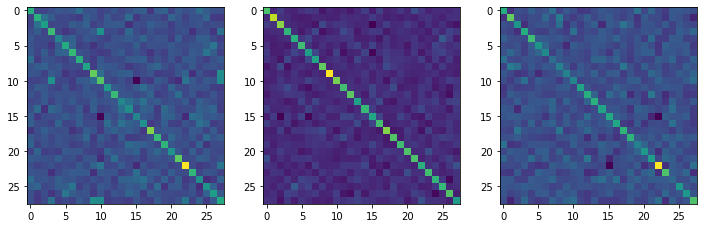

In [70]:
plot_filters(Hs_iter)

In [71]:
Ys_hat_iter = Hs_iter @ Xs_test
norm_y = (Ys_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
err_y = ((Ys_test - Ys_hat_iter)**2).sum((1,2)) / norm_y
err_y, norm_y

(array([0.2679726 , 0.02513351, 0.28401224]),
 array([1.35561893e+06, 7.80448022e+00, 9.36457366e+06]))

In [72]:
Ys_hat_iter = Hs_iter @ Xs_test
err_ys_iter, err_Hs_iter = error_metrics(Ys_hat_iter, Ys_test, Hs_iter, Hs_gt)
#models.append("VARMA-RGFI"); errs_y.append(err_mult_iter); errs_H.append(err_Hs_mult_iter)
err_ys_iter, err_Hs_iter

Error in signal y: 0.19237278410798186
Error in filter: 0.9935443659741116


(0.19237278410798186, 0.9935443659741116)